Notebook for trials of the vae model. In this notebook we will test the performance of the pretrained and finetuned vae model on the dataset. Then, with the best model we will plot the latent space and the reconstruction of some examples.

In [7]:
#Add repo path to the system path
from pathlib import Path
import os, sys
repo_path= Path.cwd().resolve()
while '.gitignore' not in os.listdir(repo_path): # while not in the root of the repo
    repo_path = repo_path.parent #go up one level
    print(repo_path)
    
sys.path.insert(0,str(repo_path)) if str(repo_path) not in sys.path else None
exp_path = Path.cwd().resolve() # path to the experiment folder
print(f"Repo Path: {repo_path}")
print(f"Experiment Path: {exp_path}")

/home/benet/tfg/experiments
/home/benet/tfg
Repo Path: /home/benet/tfg
Experiment Path: /home/benet/tfg/experiments/vae_finetuning


In [8]:
#Libraries
import yaml
import torch
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from torchvision.transforms import (
    Compose,
    Resize,
    CenterCrop,
    ToTensor,
    Normalize,
    InterpolationMode,
)
from diffusers import AutoencoderKL

# import the MRIDataset class from the dataset folder
from dataset.build_dataset import MRIDataset

np.random.seed(17844)
torch.manual_seed(17844)


In [9]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device: {device}")

config_path = exp_path / 'config_vae_finetunning.yaml'
with open(config_path) as file: # expects the config file to be in the same directory
    config = yaml.load(file, Loader=yaml.FullLoader)

# define logging directory
pipeline_dir = repo_path / config['saving']['local']['outputs_dir'] / config['saving']['local']['pipeline_name']
print(f"Pipeline Directory: {pipeline_dir}")

Device: cuda
Pipeline Directory: /home/benet/tfg/results/pipelines/fintuned_vae


In [20]:
# Dataset loading
data_dir = repo_path / config['processing']['dataset']
# Define the transformations to apply to the images
preprocess = Compose(
    [
        Resize(config['processing']['resolution'], interpolation= InterpolationMode.BILINEAR), #getattr(InterpolationMode, config['processing']['interpolation'])),  # Smaller edge is resized to 256 preserving aspect ratio
        CenterCrop(config['processing']['resolution']),  # Center crop to the desired squared resolution
        #RandomHorizontalFlip(),  # Horizontal flip may not be a good idea if we want generation only one laterality
        ToTensor(),  # Convert to PyTorch tensor
        Normalize(mean=[0.5], std=[0.5]),  # Map to (-1, 1) as a way to make data more similar to a Gaussian distribution
    ]
)

# Create dataset with the defined transformations
dataset = MRIDataset(data_dir, transform=preprocess, RGB=True) # create the dataset
# Create the dataloader
train_dataloader = DataLoader(
    dataset, batch_size=config['processing']['batch_size'], num_workers= config['processing']['num_workers'], shuffle=True
)

print(f"Dataset loaded with {len(dataset)} images of size {config['processing']['resolution']} and {config['processing']['batch_size']} batch size")

Dataset loaded with 6460 images of size 256 and 2 batch size


In [16]:
# Auxiliary function to generate latents, reconstructions, plot them and compare two VAEs

def generate_latents_and_reconstructions(dataset, vae, num_images=1, device="cpu"):
    """
    Selects random images from the dataset, encodes them into latents, and reconstructs them.

    Parameters:
    - dataset: The dataset containing images.
    - vae: The Variational Autoencoder (VAE) model.
    - num_images: Number of images to sample from the dataset.
    - device: Device to perform computations on ('cpu' or 'cuda').

    Returns:
    - images: Selected images (tensor).
    - latents: Encoded latents from VAE.
    - reconstructions: Decoded reconstructions from VAE.
    """
    indices = np.random.choice(len(dataset), num_images, replace=False)
    images = [dataset[i] for i in indices]
    images = torch.stack(images).to(device)

    with torch.no_grad():
        latents = vae.encode(images).latent_dist.sample()
        reconstructions = vae.decode(latents)

    return images, latents, reconstructions


def plot_latents_and_reconstructions(images, latents, reconstructions, loss=False):
    """
    Plots the latents and reconstructions for each image in a structured layout.

    Parameters:
    - images: Tensor of original images (already on the correct device).
    - latents: Tensor of latent representations.
    - reconstructions: Tensor of reconstructed images.
    - loss: If True, prints the MSE loss between the original and reconstructed image.
    """
    for i, image in enumerate(images):
        latent = latents[i]
        reconstruction = reconstructions[0][i]

        # Create the figure and a GridSpec layout
        fig = plt.figure(figsize=(12, 8))
        gs = fig.add_gridspec(2, 4, height_ratios=[1, 2])  # Second row is taller

        # First row: 4 subplots (latents)
        for j in range(4):
            ax = fig.add_subplot(gs[0, j])
            ax.imshow(latent[j].cpu().numpy(), cmap="gray")
            ax.set_title(f"Latent {j + 1}")

        # Second row: 2 subplots spanning 2 columns each
        ax5 = fig.add_subplot(gs[1, :2])  # Spans columns 0 and 1
        ax5.imshow(image[0].cpu(), cmap="gray")
        ax5.set_title("Original")

        ax6 = fig.add_subplot(gs[1, 2:])  # Spans columns 2 and 3
        ax6.imshow(reconstruction[0].cpu(), cmap="gray")
        ax6.set_title("Reconstruction")

        # Adjust layout
        plt.tight_layout()
        plt.show()

        # Compute and print loss if required
        if loss:
            loss_value = torch.nn.functional.mse_loss(image, reconstruction)
            print(f"Reconstruction loss: {loss_value.item()}")


def compare_vaes(dataset, vae1, vae2, num_images=100, batch_size=10, device="cuda"):
    """
    Compares the average reconstruction loss (MSE) between two VAEs with batch processing.
    
    Parameters:
    - dataset: The dataset containing images.
    - vae1: First VAE model.
    - vae2: Second VAE model.
    - num_images: Number of images to sample for comparison.
    - batch_size: Number of images processed per batch.
    - device: Device to perform computations on ('cpu' or 'cuda').
    
    Returns:
    - avg_loss_vae1: Average MSE loss for the first VAE.
    - avg_loss_vae2: Average MSE loss for the second VAE.
    """
    indices = torch.randperm(len(dataset))[:num_images]
    images = [dataset[i] for i in indices]  # Extract images
    images = torch.stack(images).to(device)  # Stack and move to device

    total_loss_vae1, total_loss_vae2 = 0.0, 0.0
    num_batches = len(images) // batch_size

    with torch.no_grad():
        for i in range(0, len(images), batch_size):
            batch = images[i : i + batch_size]

            # Encode & Decode with VAE 1
            latents_vae1 = vae1.encode(batch).latent_dist.sample()
            reconstructions_vae1 = vae1.decode(latents_vae1)[0]

            # Encode & Decode with VAE 2
            latents_vae2 = vae2.encode(batch).latent_dist.sample()
            reconstructions_vae2 = vae2.decode(latents_vae2)[0]

            # Compute MSE losses
            total_loss_vae1 += torch.nn.functional.mse_loss(batch, reconstructions_vae1).item()
            total_loss_vae2 += torch.nn.functional.mse_loss(batch, reconstructions_vae2).item()

    avg_loss_vae1 = total_loss_vae1 / num_batches
    avg_loss_vae2 = total_loss_vae2 / num_batches

    return avg_loss_vae1, avg_loss_vae2


In [13]:
device = "cpu"
# Load your fine-tuned VAE
vae = AutoencoderKL.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="vae")
vae_finetuned = AutoencoderKL.from_pretrained(pipeline_dir)
vae.to(device).eval()
vae_finetuned.to(device).eval()

AutoencoderKL(
  (encoder): Encoder(
    (conv_in): Conv2d(3, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (down_blocks): ModuleList(
      (0): DownEncoderBlock2D(
        (resnets): ModuleList(
          (0-1): 2 x ResnetBlock2D(
            (norm1): GroupNorm(32, 128, eps=1e-06, affine=True)
            (conv1): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
            (norm2): GroupNorm(32, 128, eps=1e-06, affine=True)
            (dropout): Dropout(p=0.0, inplace=False)
            (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
            (nonlinearity): SiLU()
          )
        )
        (downsamplers): ModuleList(
          (0): Downsample2D(
            (conv): Conv2d(128, 128, kernel_size=(3, 3), stride=(2, 2))
          )
        )
      )
      (1): DownEncoderBlock2D(
        (resnets): ModuleList(
          (0): ResnetBlock2D(
            (norm1): GroupNorm(32, 128, eps=1e-06, affine=True)
            (c

In [7]:
# Compare the two VAEs
loss_vae, loss_vae_finetuned = compare_vaes(dataset, vae, vae_finetuned, num_images=100, batch_size=10, device=device)

# Print the results
print(f"Average MSE Loss - Original VAE: {loss_vae:.6f}")
print(f"Average MSE Loss - Fine-Tuned VAE: {loss_vae_finetuned:.6f}")

# Determine which VAE is better
if loss_vae_finetuned < loss_vae:
    print("Fine-Tuned VAE performs better!")
    best_vae = vae_finetuned
else:
    print("Original VAE performs better!")
    best_vae = vae


Average MSE Loss - Original VAE: 0.001810
Average MSE Loss - Fine-Tuned VAE: 0.001084
Fine-Tuned VAE performs better!


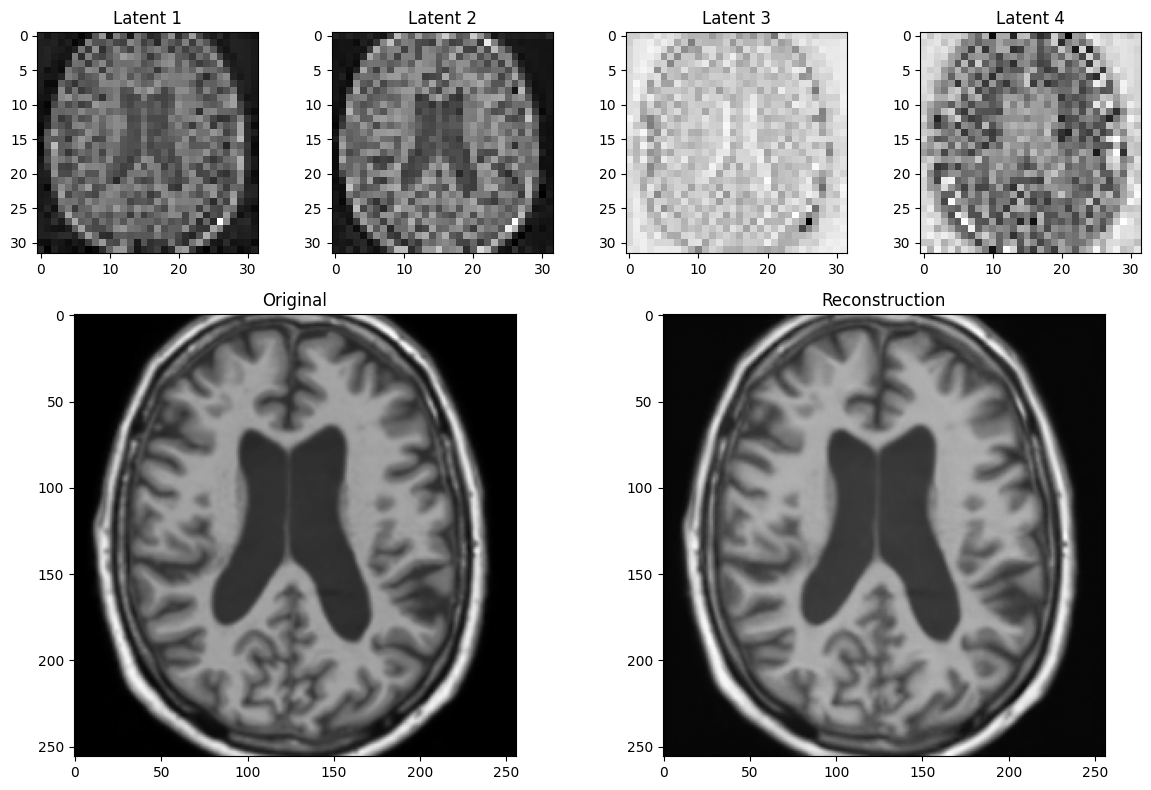

Reconstruction loss: 0.0018430681666359305


In [21]:
# Generate images, latents, and reconstructions and plot the results with the best VAE
images, latents, reconstructions = generate_latents_and_reconstructions(dataset, vae, num_images=1, device=device)
plot_latents_and_reconstructions(images, latents, reconstructions, loss=True)